In [1]:
%matplotlib inline

In [2]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

2023-02-10 18:49:55.541000: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 18:49:55.761923: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 18:49:55.802146: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os
from scipy.sparse import csr_matrix

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

2023-02-10 18:49:58.945797: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-10 18:49:58.945854: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


['default', 'despine']


In [4]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas/driver_features"

In [5]:
tp0 = TemporalProblem.load("/lustre/groups/ml01/workspace/moscot_paper/pancreas/TemporalProblem.pkl")

In [6]:
adata_shared_embedding = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad")

In [7]:
adata_imputed_counts = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_ATAC_imputation.h5ad")

In [8]:
adata_imputed_counts = adata_imputed_counts[adata_imputed_counts.obs_names.isin(tp0.adata.obs_names)]

In [9]:
adata_imputed_counts.layers["log_imputed"] = sc.pp.log1p(adata_imputed_counts.layers["X_normalized"])

In [10]:
mask = tp0.adata[:, tp0.adata.var["modality"]=="ATAC"].var_names.isin(adata_imputed_counts.var_names)

In [11]:
layer = np.zeros(tp0.adata[:,tp0.adata.var["modality"]=="ATAC"].shape)
layer[:, mask] = adata_imputed_counts.layers["log_imputed"]

In [12]:
adata_gex = tp0.adata[:, tp0.adata.var["modality"]=="GEX"]

In [13]:
sc.pp.normalize_total(adata_gex)
sc.pp.log1p(adata_gex)

/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
tp0.adata.layers["ATAC_imputed"] = csr_matrix(np.hstack((adata_gex.X.A, layer)))

In [15]:
peaks = list(tp0.adata[:,tp0.adata.var["modality"]=="ATAC"].var_names)

In [16]:
genes = list(tp0.adata[:,tp0.adata.var["modality"]=="GEX"].var_names)

In [17]:
cts = set(tp0.adata.obs["refinement"].cat.categories)

In [18]:
annotation = {"refinement": cts-set("Fev+ Alpha")}

# Alpha

In [19]:
tp0.pull(14.5, 15.5, data="refinement", subset="Alpha", key_added="Alpha_pull")

In [20]:
tp0.adata.obs["Alpha_pull_adapted"] = tp0.adata.obs["Alpha_pull"] * (tp0.adata.obs["celltype"] != "Fev+ Alpha")

In [21]:
alpha_drivers = tp0.compute_feature_correlation(obs_key="Alpha_pull_adapted", layer="ATAC_imputed", features=genes, annotation=annotation)

In [22]:
alpha_drivers 

Alpha_pull_adapted_corr  Alpha_pull_adapted_pval  \
Gcg                    0.628657             0.000000e+00   
Pou6f2                 0.586206             0.000000e+00   
Cltrn                  0.578715             0.000000e+00   
Irx2                   0.526231             0.000000e+00   
Gria2                  0.523678             0.000000e+00   
...                         ...                      ...   
Pard3                 -0.271578            5.203610e-160   
Btg2                  -0.277051            8.575059e-167   
Nkx6-1                -0.280909            1.127488e-171   
Ptma                  -0.285187            3.490752e-177   
Sox4                  -0.305937            2.198174e-205   

        Alpha_pull_adapted_qval  Alpha_pull_adapted_ci_low  \
Gcg                0.000000e+00                   0.616250   
Pou6f2             0.000000e+00                   0.572753   
Cltrn              0.000000e+00                   0.565085   
Irx2               0.000000e+00                   0.511428   
Gria2              0.000000e+00                   0.508821   
...                         ...                        ...   
Pard3             9.192836e-158                  -0.290235   
Btg2              1.612001e-164                  -0.295645   
Nkx6-1            2.296160e-169                  -0.299459   
Ptma              7.527191e-175                  -0.303686   
Sox4              5.860331e-203                  -0.324182   

        Alpha_pull_adapted_ci_high  
Gcg                       0.640752  
Pou6f2                    0.599344  
Cltrn                     0.592030  
Irx2                      0.540721  
Gria2                     0.538223  
...                            ...  
Pard3                    -0.252714  
Btg2                     -0.258246  
Nkx6-1                   -0.262147  
Ptma                     -0.266472  
Sox4                     -0.287465  

[14663 rows x 5 columns]

In [23]:
alpha_drivers.to_csv(os.path.join(output_dir, "drivers_eps_to_alpha_genes.csv"))

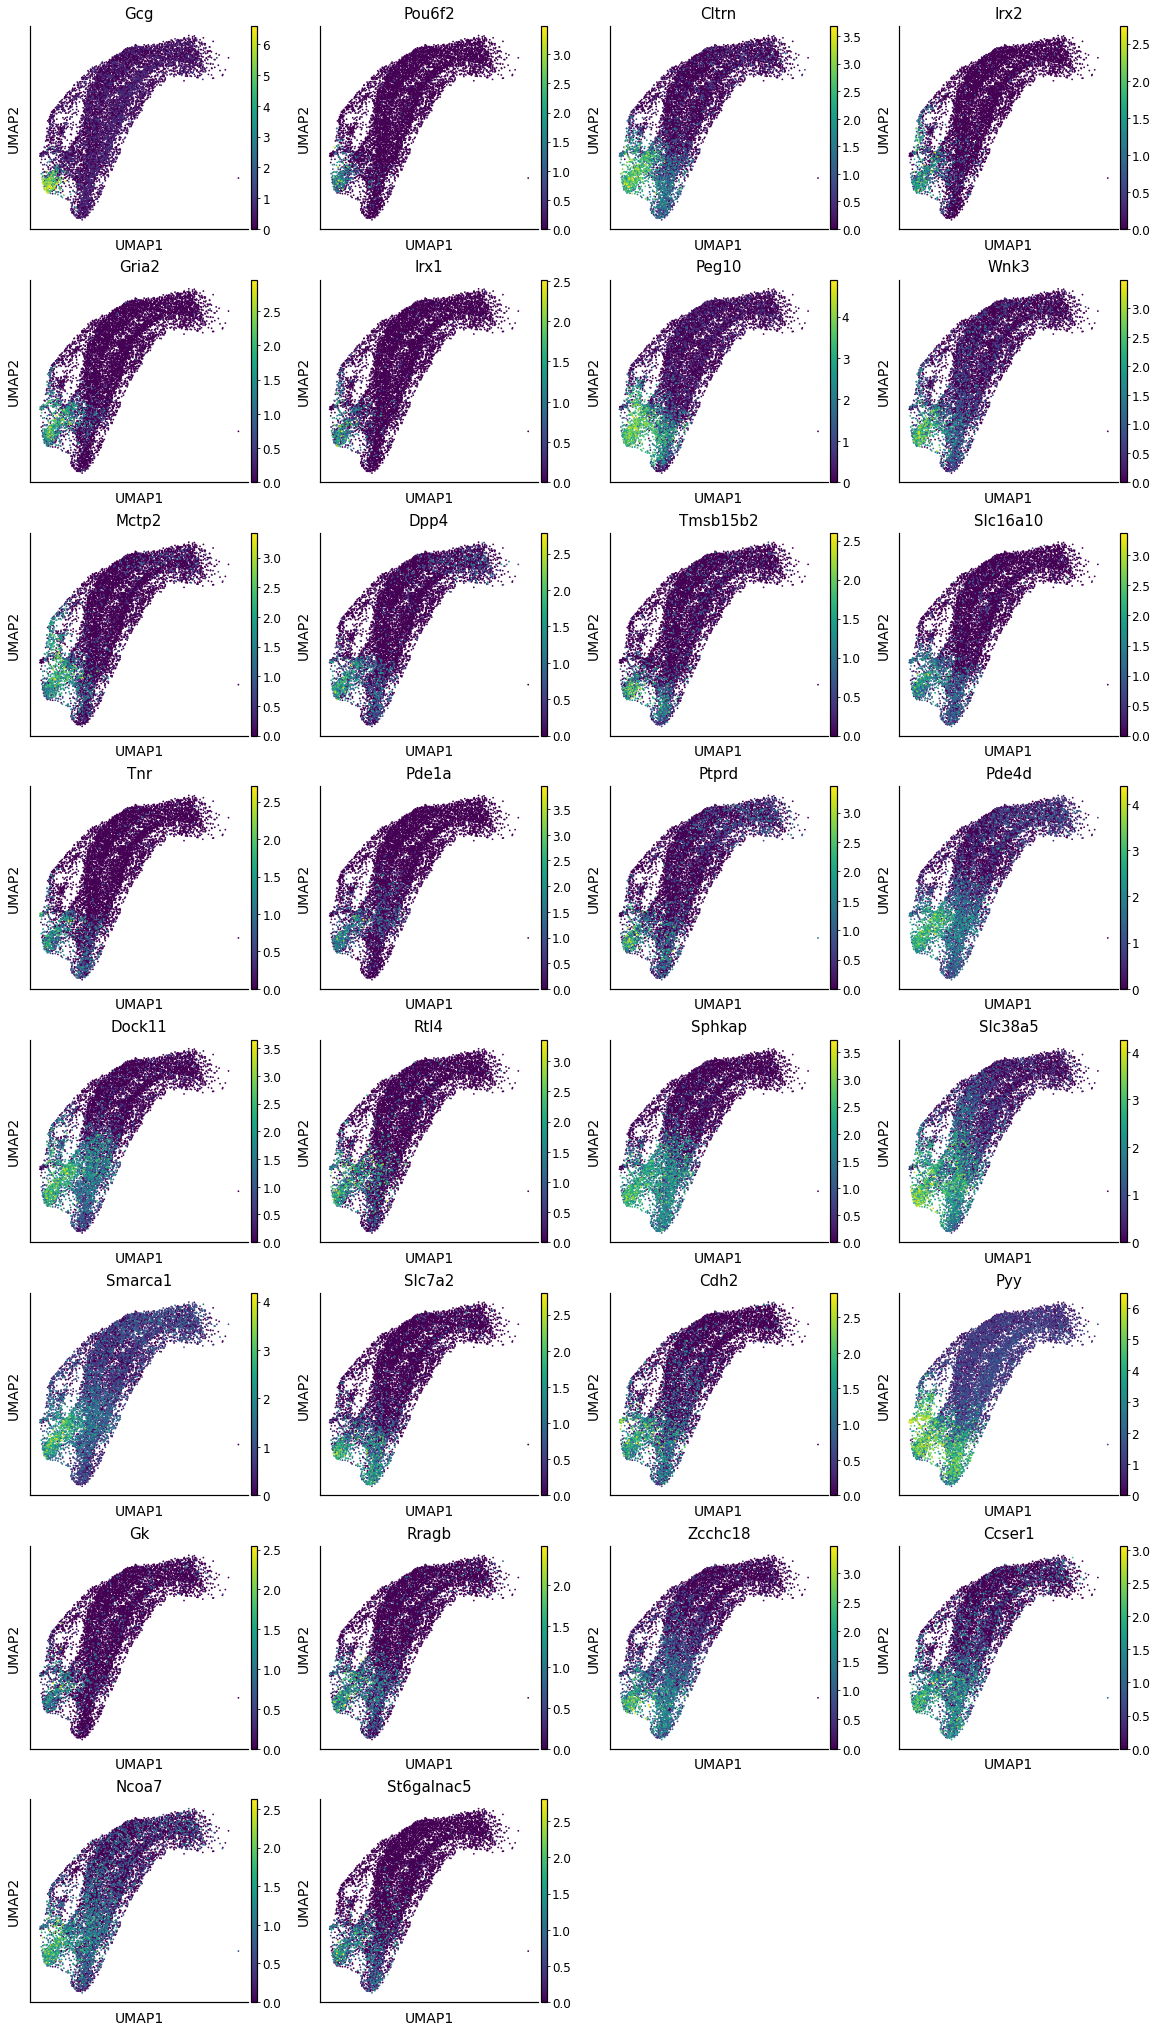

In [24]:
sc.pl.umap(adata_gex, color=alpha_drivers.index[:30])

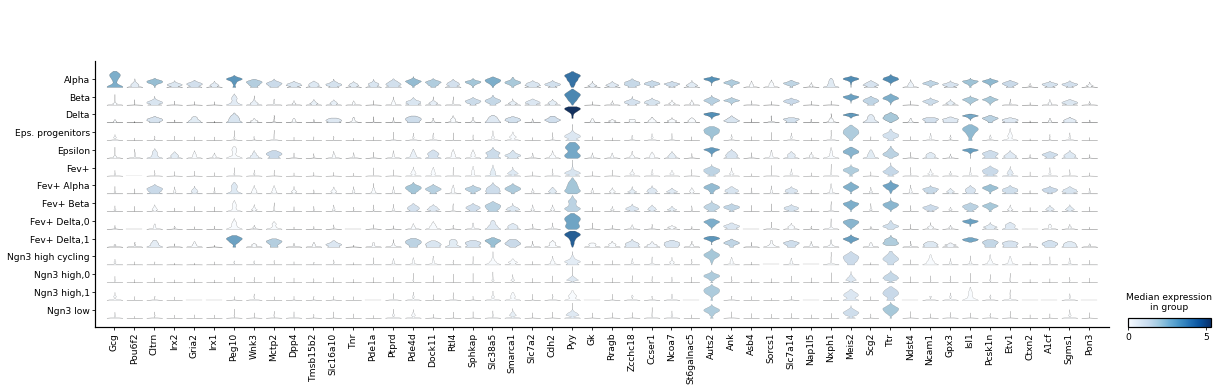

In [25]:
sc.pl.stacked_violin(adata_gex, alpha_drivers.index[:50], groupby="refinement")

In [26]:
genes_selected = ["Irx2", "Irx1", "Mctp2", "Dock11", "A1cf", "Peg10"]

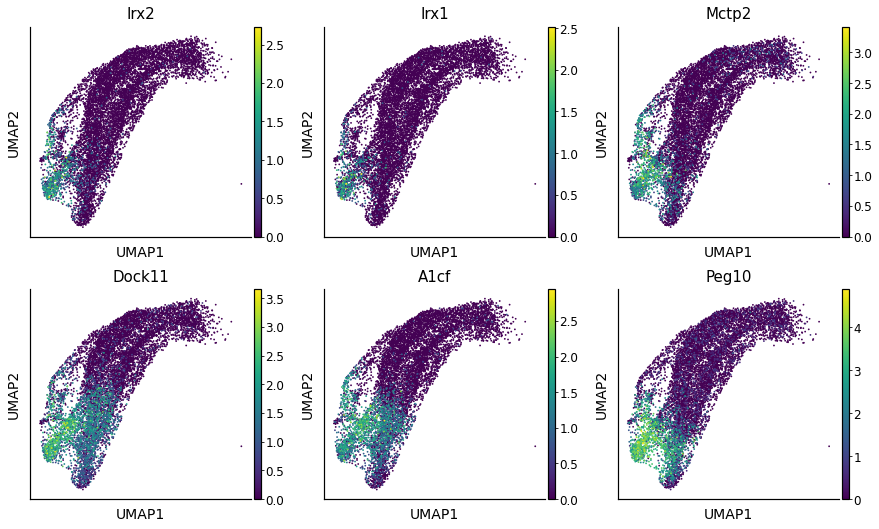

In [27]:
sc.pl.umap(adata_gex, color=genes_selected, ncols=3)

In [28]:
order_celltypes = ['Ngn3 low', 'Ngn3 high cycling', 'Ngn3 high,0', 'Ngn3 high,1', 'Eps. progenitors', 'Fev+', 'Fev+ Alpha', 
                   'Fev+ Beta', 'Fev+ Delta,0', 'Fev+ Delta,1', 'Alpha', 'Beta', 'Delta', 'Epsilon']

In [29]:
adata_gex.obs["refinement"] = adata_gex.obs["refinement"].cat.reorder_categories(order_celltypes)

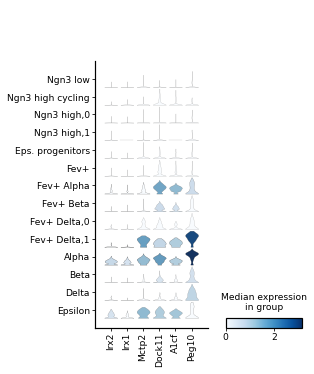

In [30]:
sc.pl.stacked_violin(adata_gex, var_names=genes_selected, groupby="refinement")

In [31]:
alpha_drivers_peaks = tp0.compute_feature_correlation(obs_key="Alpha_pull_adapted", layer="ATAC_imputed", features=peaks)

In [32]:
alpha_drivers_peaks

Alpha_pull_adapted_corr  Alpha_pull_adapted_pval  \
19-60167711-60168625                  0.652957                      0.0   
14-93825518-93826591                  0.643597                      0.0   
16-70767846-70768746                  0.634739                      0.0   
3-154084552-154085465                 0.631787                      0.0   
3-17473827-17474733                   0.630107                      0.0   
...                                        ...                      ...   
Y-2661677-2662608                          NaN                      NaN   
Y-90725776-90726677                        NaN                      NaN   
Y-90732062-90732805                        NaN                      NaN   
Y-90797268-90798083                        NaN                      NaN   
Y-90824999-90825866                        NaN                      NaN   

                       Alpha_pull_adapted_qval  Alpha_pull_adapted_ci_low  \
19-60167711-60168625                       0.0                   0.641183   
14-93825518-93826591                       0.0                   0.631576   
16-70767846-70768746                       0.0                   0.622488   
3-154084552-154085465                      0.0                   0.619460   
3-17473827-17474733                        0.0                   0.617737   
...                                        ...                        ...   
Y-2661677-2662608                          NaN                        NaN   
Y-90725776-90726677                        NaN                        NaN   
Y-90732062-90732805                        NaN                        NaN   
Y-90797268-90798083                        NaN                        NaN   
Y-90824999-90825866                        NaN                        NaN   

                       Alpha_pull_adapted_ci_high  
19-60167711-60168625                     0.664424  
14-93825518-93826591                     0.655308  
16-70767846-70768746                     0.646679  
3-154084552-154085465                    0.643803  
3-17473827-17474733                      0.642166  
...                                           ...  
Y-2661677-2662608                             NaN  
Y-90725776-90726677                           NaN  
Y-90732062-90732805                           NaN  
Y-90797268-90798083                           NaN  
Y-90824999-90825866                           NaN  

[228259 rows x 5 columns]

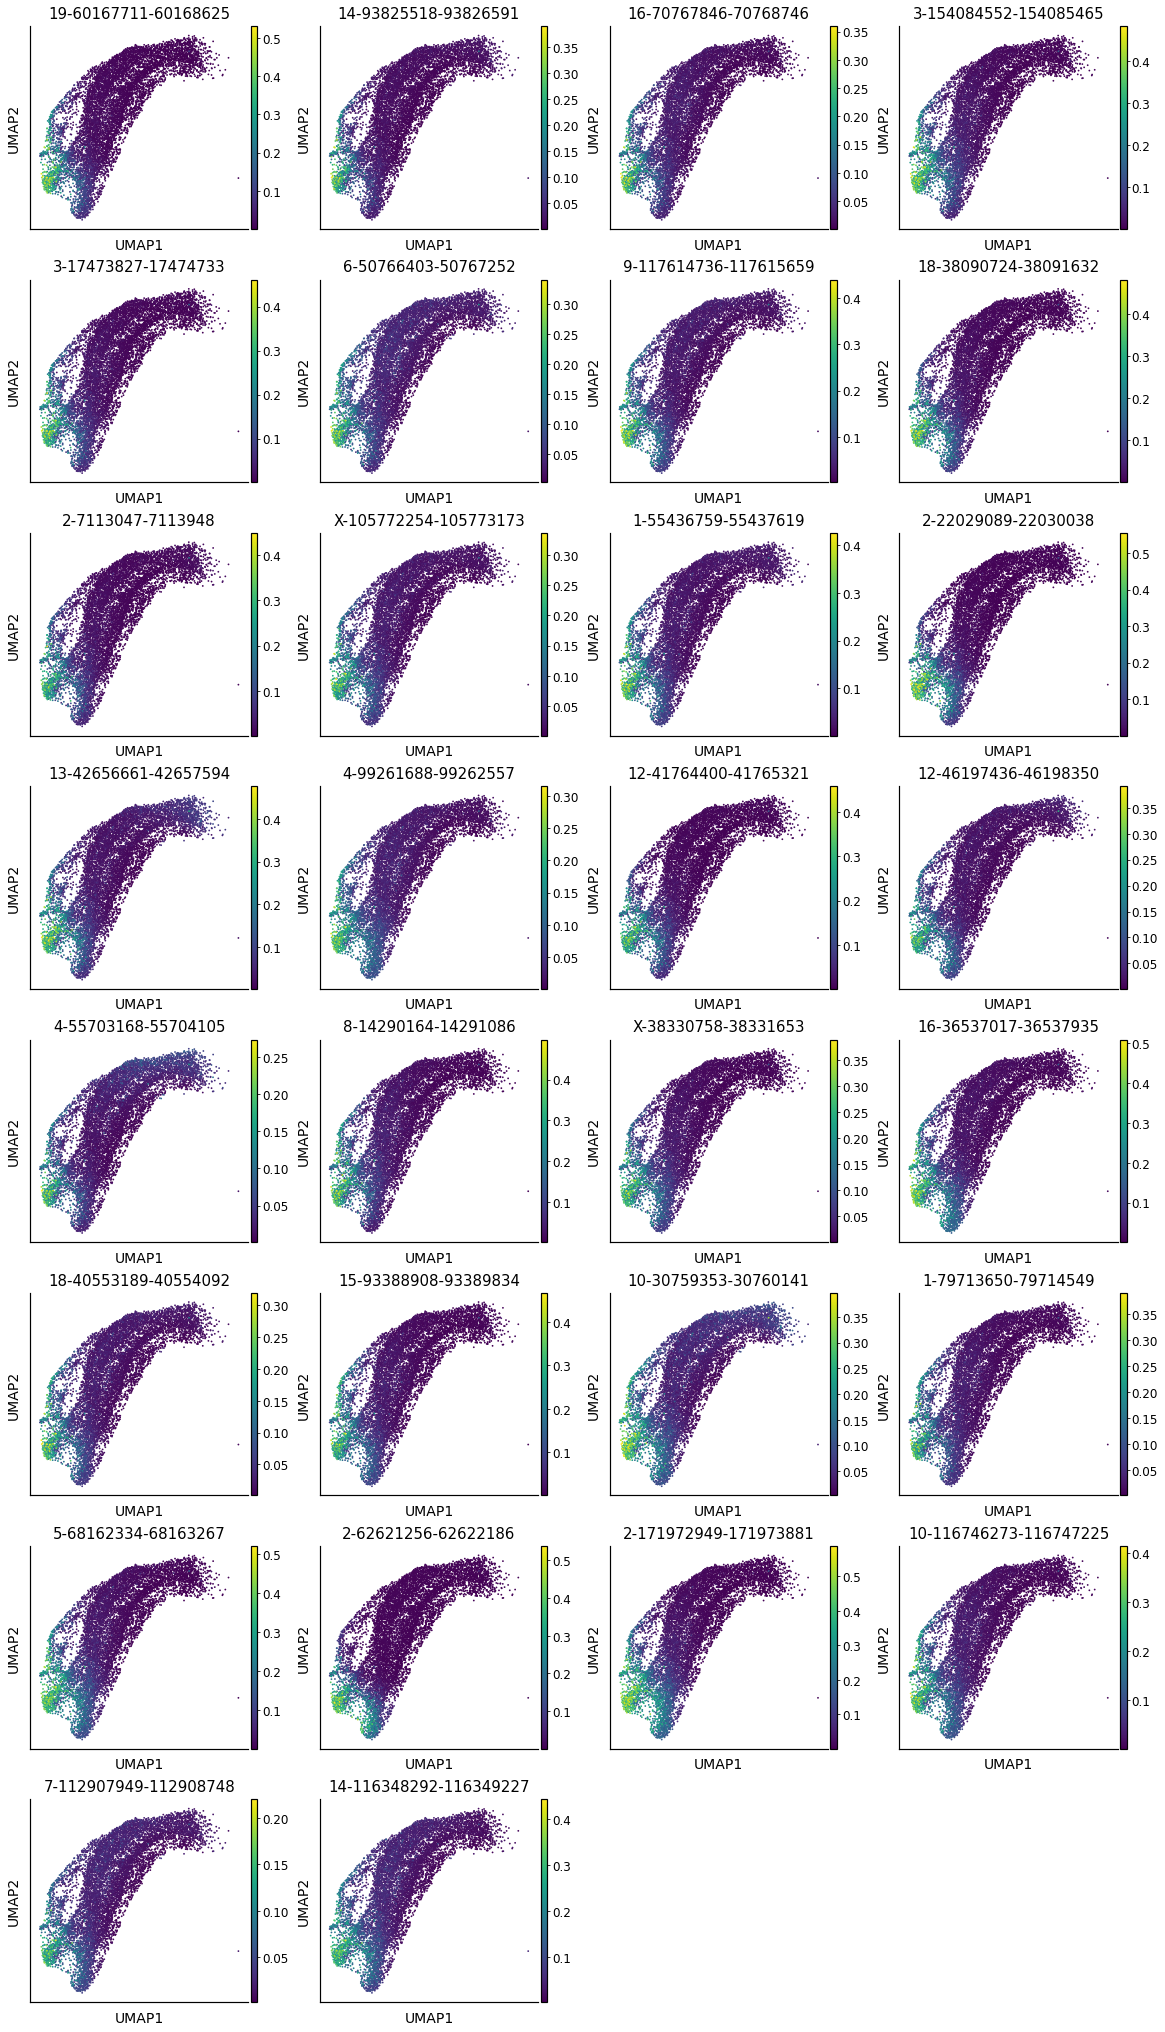

In [33]:
sc.pl.umap(adata_imputed_counts, color=alpha_drivers_peaks.index[:30], layer="log_imputed")

In [34]:
alpha_drivers_peaks.to_csv(os.path.join(output_dir, "drivers_eps_to_alpha_peaks.csv"))